# Import Library

In [67]:
# Untuk membaca dan membuat dataframe
import pandas as pd

# Mempersiapkan array untuk menghitung perhitungan matematika
import numpy as np

# Untuk membuat visualisasi data pada EDA
import seaborn as sns
import matplotlib.pyplot as plt

# Untuk menyimpan model
import pickle

# Untuk melakukan preprocessing fitur transformasi
from sklearn.preprocessing import MinMaxScaler

# Untuk melakukan pengecekan variabel yang mempunyai multikolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Dimensionality Reduction menggunakan PCA
from sklearn.decomposition import PCA

# Mencari nilai optimaldari clusters menggunakan metode elbow
from sklearn.cluster import KMeans

# Untuk membuat Silhouette Plot
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score,silhouette_samples

#Untuk mengabaikan fitur peringatan
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [68]:
data = pd.read_csv('ecommerce_data_clean.csv')

In [69]:
data1 = data.copy()

In [70]:
data.head().T

,0,1,2,3,4
order_id,AU-2015-1,AU-2015-2,AU-2015-3,AU-2015-4,AU-2015-5
order_date,2015-11-09,2015-06-30,2015-12-05,2015-05-09,2015-07-09
ship_date,2015-11-17,2015-07-02,2015-12-13,2015-05-16,2015-07-18
aging,8,2,8,7,9
ship_mode,First Class,First Class,First Class,First Class,First Class
product_category,Auto & Accessories,Auto & Accessories,Auto & Accessories,Auto & Accessories,Auto & Accessories
product,Car Media Players,Car Speakers,Car Body Covers,Car & Bike Care,Tyre
sales,140,211,117,118,250
quantity,2,3,5,2,1
discount,5,3,1,5,4


In [71]:
data['ship_mode'].value_counts()

ship_mode
Standard Class    30775
Second Class      10309
First Class        7492
Same Day           2701
45788                 1
Name: count, dtype: int64

In [72]:
data = data[data['ship_mode'] != '45788']
data1 = data1[data1['ship_mode'] != '45788']

In [73]:
data = data.drop(columns = 'segment')
data1 = data1.drop(columns = 'segment')

In [74]:
# Select only non-numeric columns for Cramér's V calculation
categorical_data = data.select_dtypes(exclude=['float64', 'int64'])

In [80]:
from sklearn.preprocessing import LabelEncoder

#Label Encoding the object dtypes.
LE=LabelEncoder()
# Apply LabelEncoder to the 'customer_name' column to create a new 'id_name' column
data['id_name'] = LE.fit_transform(data['customer_name'])
data['id_name']

0        402
1          8
2        495
3        640
4        631
        ... 
51273    761
51274    441
51275    458
51276     51
51277    455
Name: id_name, Length: 51277, dtype: int32

In [58]:
# Convert the 'order_date' column to datetime format
data1['order_date'] = pd.to_datetime(data1['order_date'])

# Calculate the metrics for RFM analysis

# Recency: Calculate the number of days since the last transaction for each customer
most_recent_date = data1['order_date'].max() + pd.Timedelta(days=1)  # Adding one day to consider the last date in the dataset
recency = data1.groupby('customer_id')['order_date'].max().reset_index()
recency['recency'] = (most_recent_date - recency['order_date']).dt.days

# Frequency: Calculate the number of transactions for each customer
frequency = data1.groupby('id_name')['order_id'].count().reset_index()
frequency.columns = ['customer_id', 'frequency']

# Monetary: Calculate the total sales for each customer
monetary = data1.groupby('customer_id')['sales'].sum().reset_index()
monetary.columns = ['customer_id', 'monetary']

# Merge the recency, frequency, and monetary dataframes
rfm = recency.merge(frequency, on='customer_id').merge(monetary, on='customer_id')

# Drop the 'order_date' column from the merged dataframe
rfm.drop(columns='order_date', inplace=True)

rfm.head()


,customer_id,recency,frequency,monetary
0,AB-0010767,22,1,159
1,AB-0010840,40,1,224
2,AB-0011247,52,1,224
3,AB-0011531,131,1,85
4,AB-0011875,77,1,213


# Check Cardinality

In [9]:
# Count unique values in each categorical column
unique_counts = categorical_data.nunique()

unique_counts

order_id            51277
order_date            365
ship_date             375
ship_mode               4
product_category        4
product                42
order_priority          4
customer_id         51277
customer_name         795
city                 3636
state                1094
country               147
region                 15
months                 12
dtype: int64

menghapus kolom yang mempunyai nilai unique yang banyak untuk menghindari high cardinality

In [10]:
# Select only non-numeric columns for Cramér's V calculation
numerical_data = data.select_dtypes(exclude=['object'])

In [11]:
numerical_data.columns

Index(['aging', 'sales', 'quantity', 'discount', 'profit', 'shipping_cost'], dtype='object')

# Encoding

In [12]:
from sklearn.preprocessing import LabelEncoder

#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in categorical_data:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [13]:
data_select = data[['ship_mode','product_category','region','months','order_priority','aging', 'sales', 'quantity', 'discount', 'shipping_cost']]
data_select.head()

,ship_mode,product_category,region,months,order_priority,aging,sales,quantity,discount,shipping_cost
0,0,0,10,9,3,8,140,2,5,4
1,0,0,4,6,3,2,211,3,3,11
2,0,0,10,2,0,8,117,5,1,3
3,0,0,5,8,1,7,118,2,5,2
4,0,0,10,5,0,9,250,1,4,16


# Scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(data_select)
scaled_data = pd.DataFrame(scaler.transform(data_select),columns= data_select.columns )
print("All features are now scaled")

All features are now scaled


In [15]:
scaled_data.head()

,ship_mode,product_category,region,months,order_priority,aging,sales,quantity,discount,shipping_cost
0,0.0,0.0,0.714286,0.818182,1.000000,0.777778,0.493088,0.25,1.00,0.2500
1,0.0,0.0,0.285714,0.545455,1.000000,0.111111,0.820276,0.50,0.50,0.6875
2,0.0,0.0,0.714286,0.181818,0.000000,0.777778,0.387097,1.00,0.00,0.1875
3,0.0,0.0,0.357143,0.727273,0.333333,0.666667,0.391705,0.25,1.00,0.1250
4,0.0,0.0,0.714286,0.454545,0.000000,0.888889,1.000000,0.00,0.75,1.0000


# PCA

In [16]:
# Melakukan reduksi dimensi dengan PCA
pca = PCA()
pca.fit(scaled_data)

PCA()

In [17]:
# Melihat ukuran data sebelum di pca
scaled_data.shape

(51277, 10)

Text(0, 0.5, 'Eigenvalues')

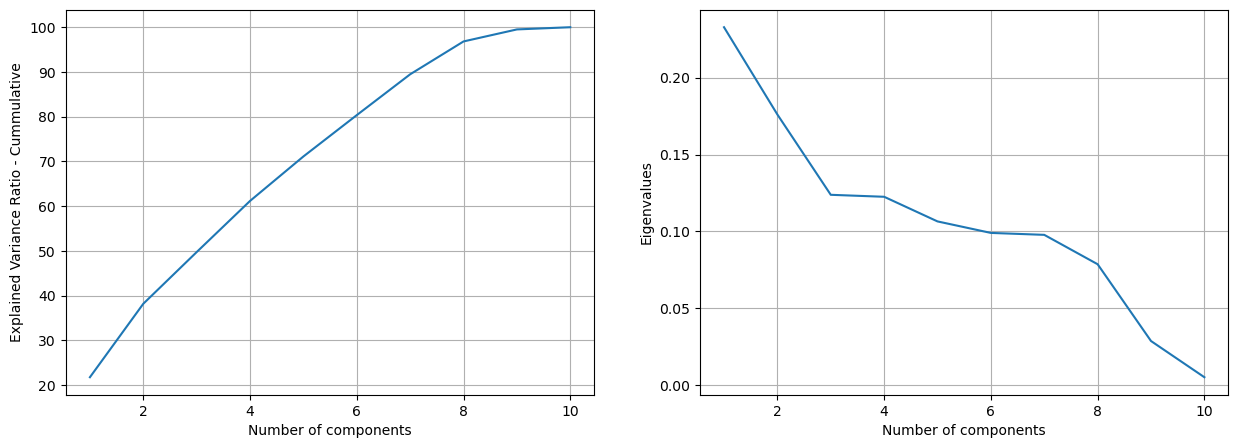

In [18]:
# Membuat plot Kumulatif dari Rasio Varians yang Dijelaskan
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')

# Plot the Eigenvalues
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(range(1, 11), pca.explained_variance_ )
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

In [19]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.80) + 1
num_features

6

In [20]:
# Mari kita latih model dengan 95% informasi kumpulan data asli

pca_comp = PCA(n_components=6)

scaled_pca = pca_comp.fit_transform(scaled_data)

# Model Definition (KMeans)

**Menggunakan Elbow method**

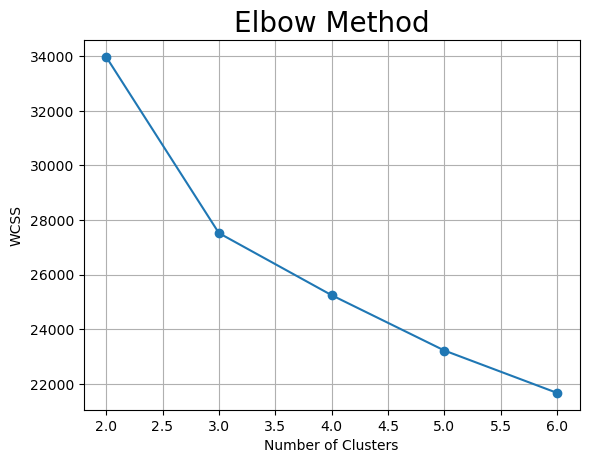

In [21]:
# Membuat grafik elbow metode untuk melihat nilai k terbaik menurut metode elbow

wcss = []
random_state = 10
max_cluster = 6
for i in range(2, max_cluster+1):

# Model definition
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
# Model training
    km.fit(scaled_pca)
    wcss.append(km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [22]:
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.3078990534766777
For n_clusters = 3 The average silhouette_score is : 0.23140625838157328
For n_clusters = 4 The average silhouette_score is : 0.2061384175191773
For n_clusters = 5 The average silhouette_score is : 0.19343549710827676


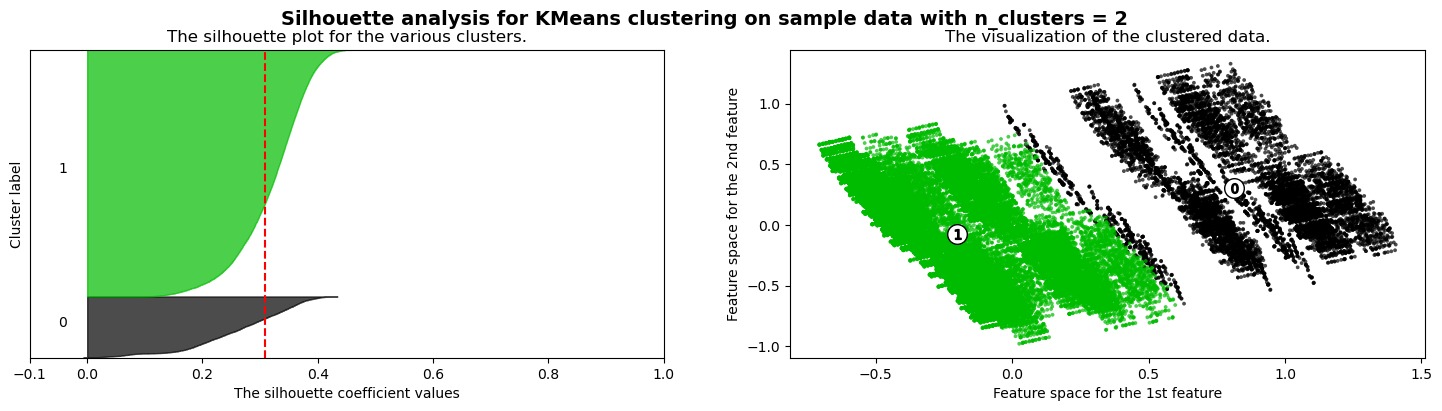

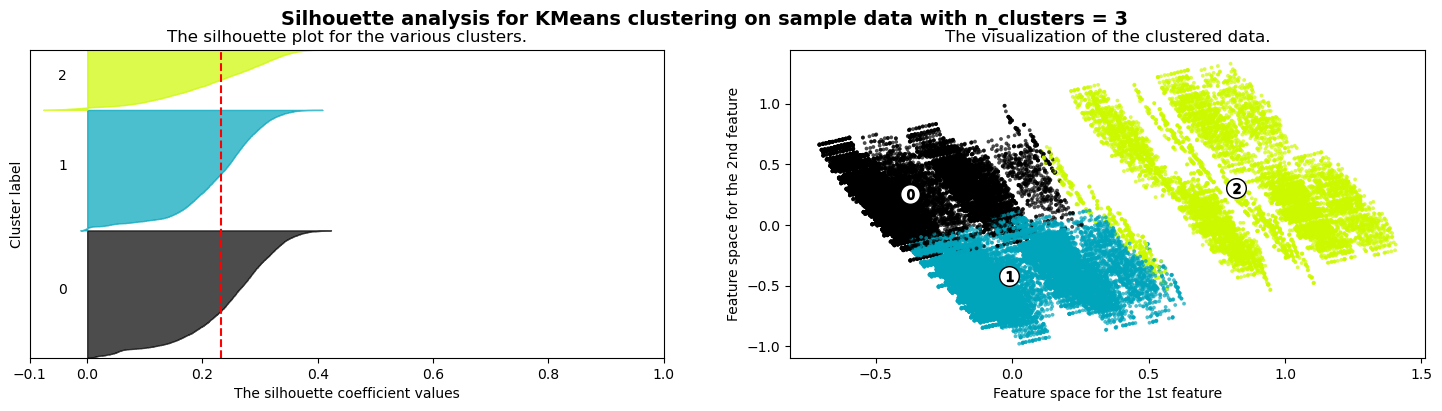

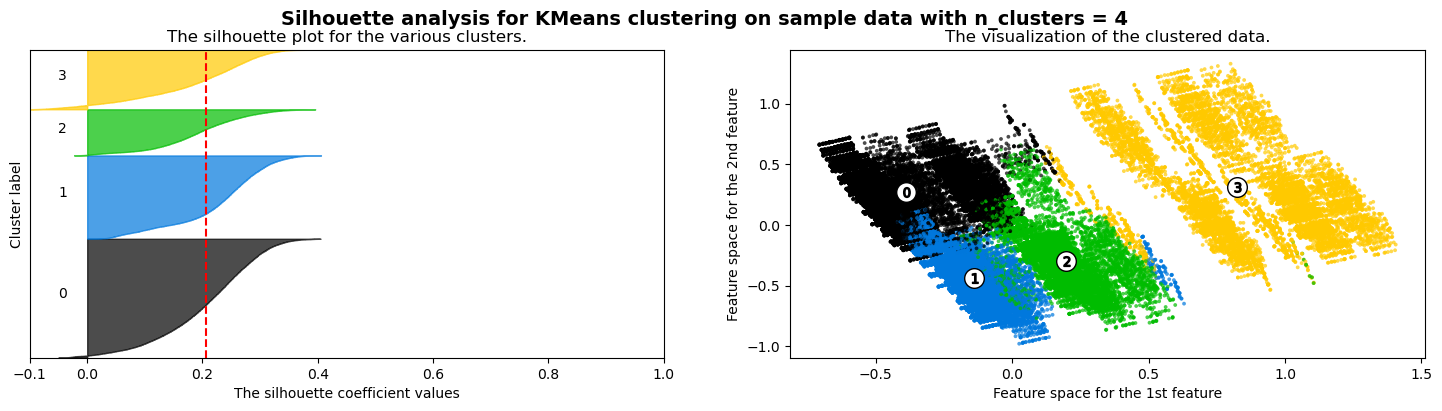

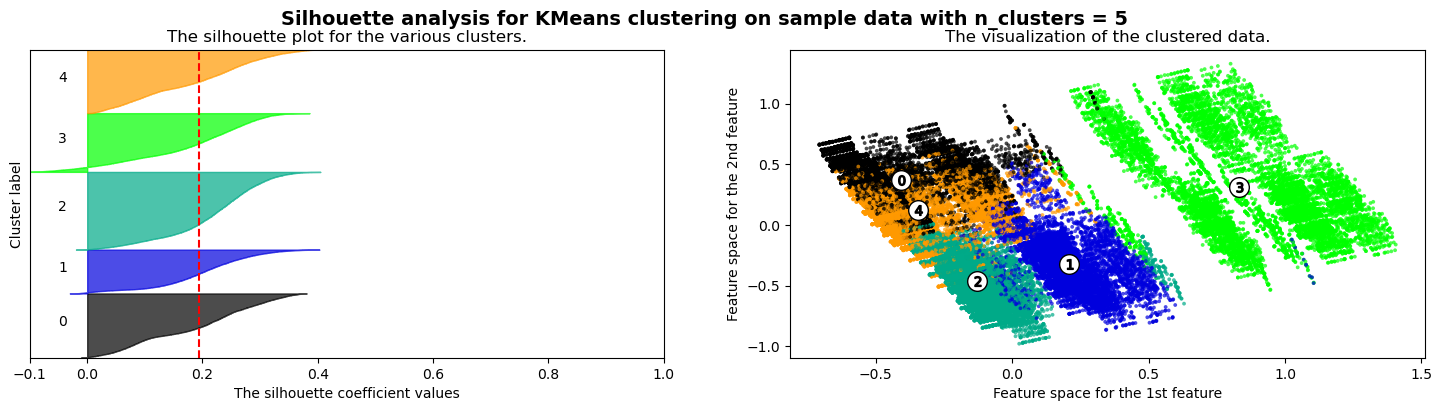

In [23]:
# Display the Silhouette Score and Plot Silhouette Plot

plot_silhouette(range(2, max_cluster), scaled_pca, random_state)

# Model Training

In [24]:
# Melakukan training pada model K-Means dengan nilai k terbaik =3
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 10)
pred = km.fit_predict(scaled_pca)
pred

array([2, 2, 2, ..., 1, 1, 1])

# EDA CLUSTER

In [25]:
# Insert clustering result into original dataset

data1['cluster'] = pred
data1.head()

,order_id,order_date,ship_date,aging,ship_mode,product_category,product,sales,quantity,discount,...,shipping_cost,order_priority,customer_id,customer_name,city,state,country,region,months,cluster
0,AU-2015-1,2015-11-09,2015-11-17,8,First Class,Auto & Accessories,Car Media Players,140,2,5,...,4,Medium,LS-001,Lane Daniels,Brisbane,Queensland,Australia,Oceania,Nov,2
1,AU-2015-2,2015-06-30,2015-07-02,2,First Class,Auto & Accessories,Car Speakers,211,3,3,...,11,Medium,IZ-002,Alvarado Kriz,Berlin,Berlin,Germany,Central,Jun,2
2,AU-2015-3,2015-12-05,2015-12-13,8,First Class,Auto & Accessories,Car Body Covers,117,5,1,...,3,Critical,EN-003,Moon Weien,Porirua,Wellington,New Zealand,Oceania,Dec,2
3,AU-2015-4,2015-05-09,2015-05-16,7,First Class,Auto & Accessories,Car & Bike Care,118,2,5,...,2,High,AN-004,Sanchez Bergman,Kabul,Kabul,Afghanistan,Central Asia,May,2
4,AU-2015-5,2015-07-09,2015-07-18,9,First Class,Auto & Accessories,Tyre,250,1,4,...,16,Critical,ON-005,Rowe Jackson,Townsville,Queensland,Australia,Oceania,Jul,2


In [26]:
data1.head().T

,0,1,2,3,4
order_id,AU-2015-1,AU-2015-2,AU-2015-3,AU-2015-4,AU-2015-5
order_date,2015-11-09,2015-06-30,2015-12-05,2015-05-09,2015-07-09
ship_date,2015-11-17,2015-07-02,2015-12-13,2015-05-16,2015-07-18
aging,8,2,8,7,9
ship_mode,First Class,First Class,First Class,First Class,First Class
product_category,Auto & Accessories,Auto & Accessories,Auto & Accessories,Auto & Accessories,Auto & Accessories
product,Car Media Players,Car Speakers,Car Body Covers,Car & Bike Care,Tyre
sales,140,211,117,118,250
quantity,2,3,5,2,1
discount,5,3,1,5,4


In [27]:
data1['cluster'] = data1['cluster'].replace('high','gold',regex = True)
data1['cluster'] = data1['cluster'].replace('medium','silver',regex = True)
data1['cluster'] = data1['cluster'].replace('low','bronze',regex = True)

In [28]:
# Misalkan Anda memiliki kolom 'cluster' yang berisi label kluster untuk setiap data dalam DataFrame 'data1'

# Kelompokkan data berdasarkan label kluster dan hitung rata-rata discount
disc_by_cluster = data1.groupby('cluster')['discount'].mean()

# Tampilkan hasilnya
disc_by_cluster


cluster
0    2.941096
1    3.059815
2    2.990510
Name: discount, dtype: float64

In [29]:
data1['cluster'].value_counts()

cluster
0    21204
1    20062
2    10011
Name: count, dtype: int64

In [30]:
# Misalkan Anda memiliki kolom 'cluster' yang berisi label kluster untuk setiap data dalam DataFrame 'data1'

# Kelompokkan data berdasarkan label kluster dan hitung rata-rata aging
aging_by_cluster = data1.groupby('cluster')['aging'].mean()

# Tampilkan hasilnya
aging_by_cluster


cluster
0    5.468685
1    5.456036
2    4.400759
Name: aging, dtype: float64

In [31]:
# Mengurutkan hasil kelompokan berdasarkan rata-rata 'sales' dari yang terbesar
sales_by_country_cluster = data1.groupby(['months','country', 'cluster','product_category','product'])['sales'].mean().reset_index()
sales_by_country_cluster_sorted = sales_by_country_cluster.sort_values(by='sales', ascending=False)

# Tampilkan hasilnya
sales_by_country_cluster_sorted.head()

,months,country,cluster,product_category,product,sales
8910,Jun,Australia,2,Auto & Accessories,Tyre,250.0
8426,Jul,Poland,2,Auto & Accessories,Tyre,250.0
9068,Jun,Chile,2,Auto & Accessories,Tyre,250.0
9056,Jun,Canada,2,Auto & Accessories,Tyre,250.0
9036,Jun,Cameroon,2,Auto & Accessories,Tyre,250.0


In [32]:
# Mengurutkan hasil kelompokan berdasarkan rata-rata 'sales' dari yang terbesar
sales_by_op_cluster = data1.groupby(['order_priority', 'cluster'])['sales'].mean().reset_index()
sales_by_op_cluster_sorted = sales_by_op_cluster.sort_values(by='sales', ascending=False)

# Tampilkan hasilnya
sales_by_op_cluster_sorted.head()


,order_priority,cluster,sales
3,High,0,218.703008
0,Critical,0,218.545667
6,Low,0,217.272152
8,Medium,0,216.663590
5,High,2,146.138735


In [33]:
# Misalkan Anda memiliki kolom 'cluster' yang berisi label kluster untuk setiap data dalam DataFrame 'data1'

# Kelompokkan data berdasarkan label kluster dan hitung rata-rata profit
sales_by_cluster = data1.groupby('cluster')['sales'].mean().reset_index()
sales_by_cluster_sorted = sales_by_cluster.sort_values(by='sales', ascending=False)
# Tampilkan hasilnya
sales_by_cluster_sorted.set_index('cluster')


,sales
cluster,
0,217.228400
2,145.605534
1,97.567890


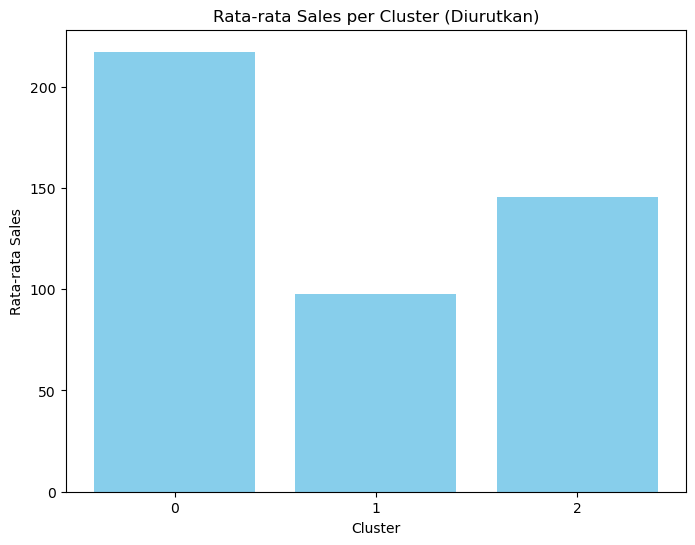

In [34]:
# Data hasil pengelompokan yang sudah diurutkan
cluster_labels = sales_by_cluster_sorted['cluster']
mean_sales = sales_by_cluster_sorted['sales']

# Membuat bar plot
plt.figure(figsize=(8, 6))
plt.bar(cluster_labels, mean_sales, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Rata-rata Sales')
plt.title('Rata-rata Sales per Cluster (Diurutkan)')
plt.xticks(cluster_labels)  # Menampilkan label kluster di sumbu x
plt.show()


0 = gold

2 = bronze

1  = silver

In [35]:
data1.shape

(51277, 21)

# Model Saving

In [36]:
# Untuk menyimpan model kita menggunakan module pickle

with open('model_scaler_cluster.pkl', 'wb') as file_1:
  pickle.dump(scaler, file_1) # ini agar di ipynb data inference kita tinggal transform saja

with open('model_kmeans.pkl', 'wb') as file_2:
  pickle.dump(km, file_2) # ini agar di ipynb data inference kita tinggal transform saja

with open('model_pca.pkl', 'wb') as file_3:
  pickle.dump(pca_comp, file_3) # ini agar di ipynb data inference kita tinggal transform saja

# CSV Saving

In [37]:
data1.to_csv('data_cluster.csv',index = False)

In [38]:
data1['order_priority'].value_counts()

order_priority
Medium      29430
High        15497
Critical     3926
Low          2424
Name: count, dtype: int64

In [39]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51277 entries, 0 to 51277
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   order_id          51277 non-null  object
 1   order_date        51277 non-null  object
 2   ship_date         51277 non-null  object
 3   aging             51277 non-null  int64 
 4   ship_mode         51277 non-null  object
 5   product_category  51277 non-null  object
 6   product           51277 non-null  object
 7   sales             51277 non-null  int64 
 8   quantity          51277 non-null  int64 
 9   discount          51277 non-null  int64 
 10  profit            51277 non-null  int64 
 11  shipping_cost     51277 non-null  int64 
 12  order_priority    51277 non-null  object
 13  customer_id       51277 non-null  object
 14  customer_name     51277 non-null  object
 15  city              51277 non-null  object
 16  state             51277 non-null  object
 17  country          

In [40]:
data1[['ship_mode','product_category','region','months','order_priority','aging', 'sales', 'quantity', 'discount', 'shipping_cost']].describe()

,aging,sales,quantity,discount,shipping_cost
count,51277.000000,51277.000000,51277.000000,51277.000000,51277.000000
mean,5.255241,156.428321,2.997270,2.997192,6.831035
std,2.960071,65.779655,1.413383,1.411422,4.915044
min,1.000000,33.000000,1.000000,1.000000,0.000000
25%,3.000000,109.000000,2.000000,2.000000,2.000000
50%,5.000000,159.000000,3.000000,3.000000,6.000000
75%,8.000000,218.000000,4.000000,4.000000,12.000000
max,10.000000,250.000000,5.000000,5.000000,16.000000


In [49]:
data1['customer_name'].value_counts()

customer_name
Mcclain O'Donnell     108
Spears Thornton       106
Booth Pistole         102
Flores Brooks         102
Bates Gockenbach      102
                     ... 
Fleming Foster         35
Wheeler Donatelli      34
Kelley Devincentis     31
Beasley Pawlan         31
Oconnor Nelson         29
Name: count, Length: 795, dtype: int64